In [1]:
# # Requerimientos de librerías:
# !pip install spacy
# !python -m spacy download es_core_news_md

# !pip install transformers
# !pip install transformers scipy ftfy accelerate

# !git clone https://github.com/JorgeSauri/COMSINT.git 

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
import numpy as np
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
from recomendaciones_comsint import Recomendador

c:\Users\jsaur\anaconda3\envs\ENV1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Con tamaño embeddings 256
- CNN de max 512 kernels (v4)

In [4]:
version = 4

recomendador256 = Recomendador(fuente='recetario_mexicano_small.csv',
                            nutricion = 'nutricion_mejorado.csv',
                            canasta='canasta_basica.csv')

recomendador256.CargarModelo(emb_size=128, version=version)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Modelo Modelos/Modelo_Nut_FV_DistilBERT_04_EMBED-128_CNN.h5 cargado con éxito.
Modelo Modelos/Modelo_Precios_FV_DistilBERT_04_EMBED-128_CNN.h5 cargado con éxito.


Generando 10 recetas aleatorias, esto puede tardar varios minutos...


<AxesSubplot:>

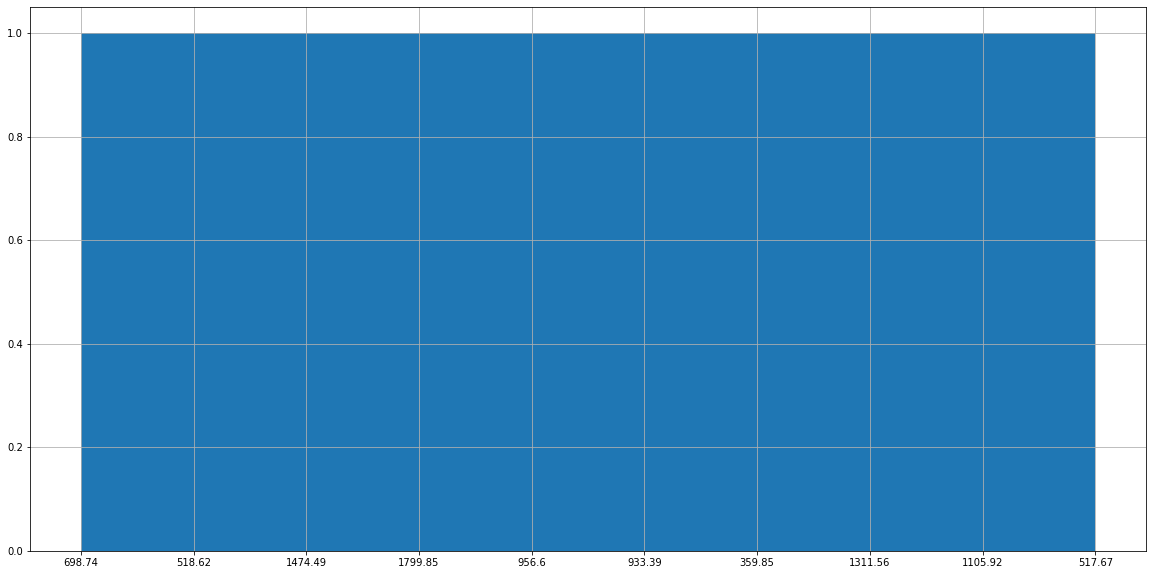

In [5]:
test = recomendador256.generar_dataset_entrenamiento_nut(df_nutricionales='nutricion_mejorado.csv', 
                                                  min_ingredientes=5, max_ingredientes=11,
                                                  min_unidades=1, max_unidades=10,
                                                  min_kcal=300, max_kcal= 1800,
                                                  numero_recetas=10, _INTENTOS=5,
                                                  )

df = pd.DataFrame(test, columns=['ingredientes', 'kcal', 'carbs', 'prot', 'grasas']) 
plt.figure(figsize=(20,10))
df['kcal'].hist()

* Entrenar información nutricional

In [ ]:
recomendador256.NUM_RECETAS = 100
recomendador256.EMB_SIZE = 256
BATCHSIZE = 8
ITER = 4
INITIAL_EPOCH = 0
EPOCHS = recomendador256.NUM_RECETAS // BATCHSIZE
#EPOCHS = 15
LR = 1e-4

Rangos_kcal = [
                (300, 800),
                (801, 1200),
                (1201, 1700)           
                #(500, 1500)              
              ]

Its = []
Valmaes = []

Histories = []
val_mae = 1000
MAX_VAL_MAE = 20

iteracion = 0
#for iteracion in range(ITER):
while val_mae > MAX_VAL_MAE:
  MINU = 1 
  MAXU = 10  
  #INITIAL_EPOCH = 0
  

  for ik in range(len(Rangos_kcal)):
    MINK, MAXK = Rangos_kcal[ik]
    print('\nITERACIÓN:', iteracion+1)
    print('min unidades:',MINU, ' max unidades:', MAXU)
    print('min kcal:', MINK, ' max kcal:', MAXK)
    print('Entrenando desde epoch', INITIAL_EPOCH)
    print('------------------------------------------\n')
    try:
      modelo256, history = recomendador256.EntrenarModelo(df_nutricionales='nutricion_mejorado.csv',
                                    #df_training='recipes_con_info_nutricional.csv',
                                    #df_test='recetas_test.csv', 
                                    #df_val='recetas_val.csv',
                                    learning_rate=LR,
                                    version=version, 
                                    initial_epoch = INITIAL_EPOCH,                             
                                    epochs=INITIAL_EPOCH + EPOCHS, 
                                    batch_size=BATCHSIZE,
                                    kernels=128,                                             
                                    min_ingredientes=5, max_ingredientes=11,                                  
                                    min_unidades=MINU, max_unidades=MAXU,  
                                    min_kcal=MINK, max_kcal= MAXK,                             
                                    save=True, verbose=True)
      INITIAL_EPOCH = history.epoch[-1]

      iteracion += 1
      val_mae = float(history.history['val_mae'][-1])
      Its.append(iteracion)
      Valmaes.append(val_mae)
      if val_mae <= MAX_VAL_MAE: break

      Histories.append(history)
    except:
      print('Falló al entrenar en interación', iteracion)
      pass
    
dfVM = pd.DataFrame({'iteracion':Its, 'val_mae':Valmaes}, columns=['iteracion', 'val_mae'])
dfVM.plot(kind='bar', x='iteracion', y='val_mae')

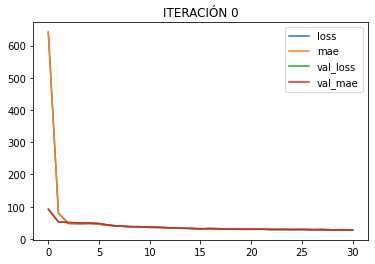

LOSS: 28.197813034057617  -- MAE: 28.197813034057617  -- VAL_LOSS: 28.014734268188477  -- VAL_MAE: 28.014734268188477
----------------------------------------------------------


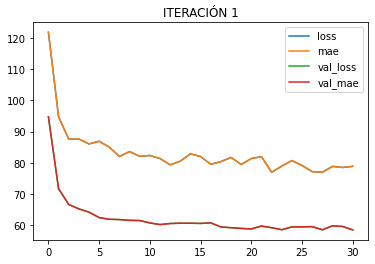

LOSS: 78.85263061523438  -- MAE: 78.85263061523438  -- VAL_LOSS: 58.481346130371094  -- VAL_MAE: 58.481346130371094
----------------------------------------------------------


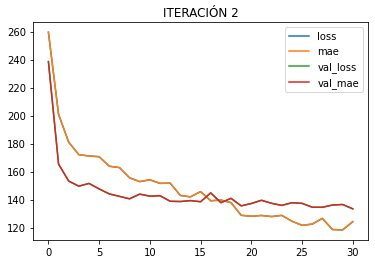

LOSS: 124.19448852539062  -- MAE: 124.19448852539062  -- VAL_LOSS: 133.3741455078125  -- VAL_MAE: 133.3741455078125
----------------------------------------------------------


In [15]:
for i in range(len(Histories)):
    history = Histories[i]    
    pd.DataFrame(history.history).plot()
    plt.title('ITERACIÓN ' + str(i))
    plt.show()
    print('LOSS:',history.history['loss'][-1], ' -- MAE:', history.history['mae'][-1], 
          ' -- VAL_LOSS:', history.history['val_loss'][-1], ' -- VAL_MAE:', history.history['val_mae'][-1])
    print('----------------------------------------------------------')

* Entrenar precios

In [ ]:
recomendador256.NUM_RECETAS = 500
recomendador256.EMB_SIZE = 256
BATCHSIZE = 32
ITER = 10
INITIAL_EPOCH = 0
EPOCHS = recomendador256.NUM_RECETAS // BATCHSIZE


Histories_precios = []
for iteracion in range(ITER):
    print('\nITERACIÓN:', iteracion+1)
    print('Entrenando desde epoch', INITIAL_EPOCH)
    print('------------------------------------------\n')
    modelo256_precios, history_precios = recomendador256.EntrenarModeloPrecios(
                                    df_precios='lista_precios_profeco_2022.csv',                                   
                                    learning_rate=1e-4,
                                    version=version, 
                                    initial_epoch = INITIAL_EPOCH,                             
                                    epochs=INITIAL_EPOCH + EPOCHS, 
                                    min_ingredientes=5, max_ingredientes=11,                                  
                                    min_unidades=MINU, max_unidades=MAXU,
                                    batch_size=BATCHSIZE,
                                    kernels=128,                                                                         
                                    save=True, verbose=True)
    INITIAL_EPOCH = history_precios.epoch[-1]

    Histories_precios.append(history_precios)

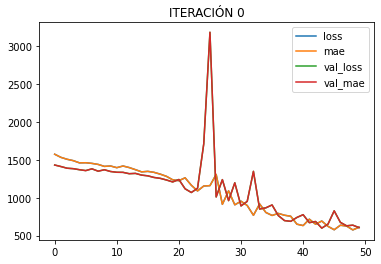

LOSS: 610.884521484375  -- MAE: 610.884521484375  -- VAL_LOSS: 605.876708984375  -- VAL_MAE: 605.876708984375
----------------------------------------------------------


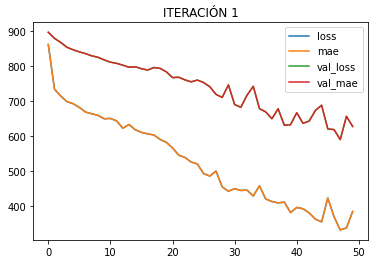

LOSS: 384.781494140625  -- MAE: 384.781494140625  -- VAL_LOSS: 627.9765014648438  -- VAL_MAE: 627.9765014648438
----------------------------------------------------------


In [10]:
for i in range(len(Histories_precios)):
    history = Histories_precios[i]    
    pd.DataFrame(history.history).plot()
    plt.title('ITERACIÓN ' + str(i))
    plt.show()
    print('LOSS:',history.history['loss'][-1], ' -- MAE:', history.history['mae'][-1], 
          ' -- VAL_LOSS:', history.history['val_loss'][-1], ' -- VAL_MAE:', history.history['val_mae'][-1])
    print('----------------------------------------------------------')